In [1]:
using Images
using PyPlot

include("Common.jl")

Main.Common

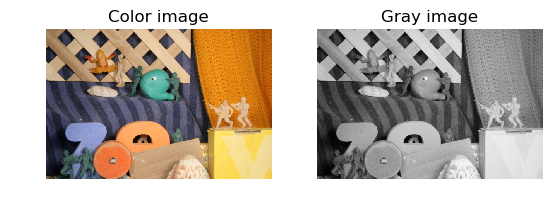

In [2]:
#---------------------------------------------------------
# Loads grayscale and color image given PNG filename.
#
# INPUTS:
#   filename     given PNG image file
#
# OUTPUTS:
#   gray         single precision grayscale image
#   rgb          single precision color image
#
#---------------------------------------------------------
function loadimage(filename)
  rgb = PyPlot.imread(filename)
  rgb = Float64.(rgb)
  gray = Common.rgb2gray(rgb)
  return gray::Array{Float64,2}, rgb::Array{Float64,3}
end

# Load both colored and grayscale image from PNG file
gray,rgb = loadimage("a3p1.png")

figure()
subplot(1,2,1); imshow(rgb,interpolation="none"); axis("off"); title("Color image");
subplot(1,2,2); imshow(gray,"gray",interpolation="none"); axis("off"); title("Gray image");


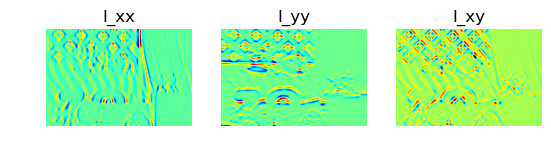

In [3]:
#---------------------------------------------------------
# Computes entries of Hessian matrix.
#
# INPUTS:
#   img             grayscale color image
#   sigma           std for presmoothing image
#   fsize           filter size for smoothing
#
# OUTPUTS:
#   I_xx       second derivative in x-direction
#   I_yy       second derivative in y-direction
#   I_xy       derivative in x- and y-direction
#
#---------------------------------------------------------
function computehessian(img::Array{Float64,2},sigma::Float64,fsize::Int)

  # Smoothing and derivative filters
  g = Common.gauss2d(sigma, [fsize, fsize])
  dx = [[0, -0.5, 0] [0, 0, 0] [0, 0.5, 0]]

  # Compute first derivatives
  img_smoothed = imfilter(img, centered(g), "replicate")
  I_x = imfilter(img_smoothed, centered(dx), "replicate")
  I_y = imfilter(img_smoothed, centered(dx'), "replicate")

  # compute second derivatives
  I_xx = imfilter(I_x, centered(dx), "replicate")
  I_yy = imfilter(I_y, centered(dx'), "replicate")
  I_xy = imfilter(I_x, centered(dx'), "replicate")

  return I_xx::Array{Float64,2},I_yy::Array{Float64,2},I_xy::Array{Float64,2}
end

# Compute the three components of the Hessian matrix
sigma = 4.5               # std for presmoothing image
fsize = 25                # filter size for smoothing
I_xx,I_yy,I_xy = computehessian(gray,sigma,fsize)
figure()
subplot(1,3,1); imshow(I_xx,"jet",interpolation="none"); axis("off"); title("I_xx");
subplot(1,3,2); imshow(I_yy,"jet",interpolation="none"); axis("off"); title("I_yy");
subplot(1,3,3); imshow(I_xy,"jet",interpolation="none"); axis("off"); title("I_xy");

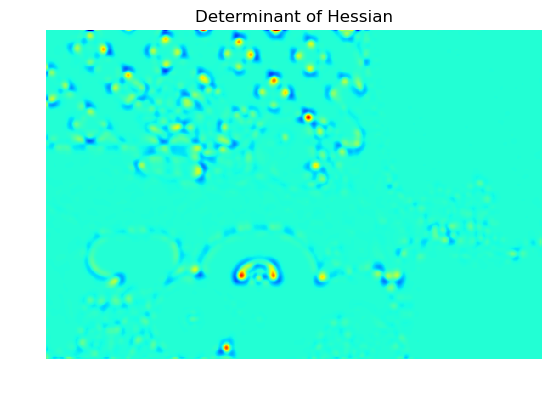

In [4]:
#---------------------------------------------------------
# Computes function values of Hessian criterion.
#
# INPUTS:
#   I_xx       second derivative in x-direction
#   I_yy       second derivative in y-direction
#   I_xy       derivative in x- and y-direction
#   sigma      std that was used for smoothing image
#
# OUTPUTS:
#   criterion  function score
#
#---------------------------------------------------------
function computecriterion(I_xx::Array{Float64,2},I_yy::Array{Float64,2},I_xy::Array{Float64,2}, sigma::Float64)
  det = I_xx.*I_yy - I_xy.^2
  criterion = sigma^4 * det
  return criterion::Array{Float64,2}
end

# Compute Hessian based corner criterion
criterion = computecriterion(I_xx,I_yy,I_xy,sigma)

# Display Hessian criterion image
figure(); imshow(criterion,"jet",interpolation="none"); axis("off"); title("Determinant of Hessian");

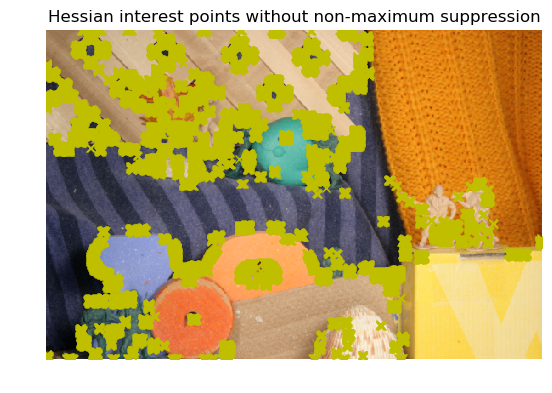

In [5]:
# Threshold corner criterion
threshold = 1e-3          # Corner criterion threshold
mask = criterion .> threshold
rows, columns = Common.findnonzero(mask)
figure(); imshow(rgb); plot(columns.-1,rows.-1,"xy",linewidth=8); axis("off");
title("Hessian interest points without non-maximum suppression");

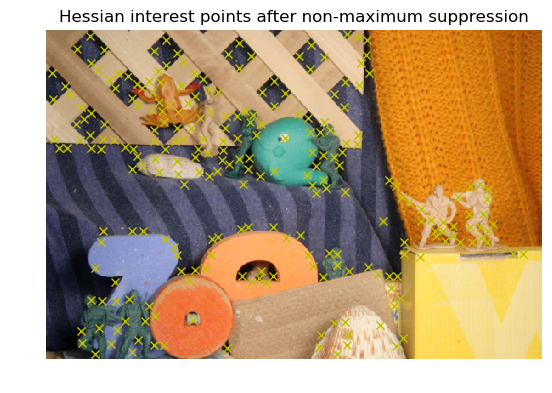

In [6]:
#---------------------------------------------------------
# Non-maximum suppression of criterion function values.
#   Extracts local maxima within a 5x5 window and
#   allows multiple points with equal values within the same window.
#   Discards interest points in a 5 pixel boundary.
#   Applies thresholding with the given threshold.
#
# INPUTS:
#   criterion  function score
#   thresh     param for thresholding
#
# OUTPUTS:
#   rows        row positions of kept interest points
#   columns     column positions of kept interest points
#
#---------------------------------------------------------
function nonmaxsupp(criterion::Array{Float64,2}, thresh::Float64)
  # apply maximum filter
  criterion_max = Common.nlfilter(criterion, maximum, 5, 5, Fill(-Inf))

  # if value is local maximum and above threshold, keep it !
  mask = (criterion .>= criterion_max) .* (criterion .> thresh)

  # Get rid of interest points close to the boundaries
  k = 4 # bndry - 1
  mask[1:1+k,:] .= 0
  mask[end-k+1:end,:] .= 0
  mask[:,1:1+k] .= 0
  mask[:,end-k+1:end] .= 0
  rows,columns = Common.findnonzero(mask)

  return rows::Array{Int,1},columns::Array{Int,1}
end

# Apply non-maximum suppression
rows,columns = nonmaxsupp(criterion,threshold)

# Display interest points on top of color image
figure(); imshow(rgb); plot(columns.-1,rows.-1,"xy",linewidth=8); axis("off");
title("Hessian interest points after non-maximum suppression");